In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy
import scipy
import scipy.constants as cnst
import glob
import re

4.1605091105527635e-05

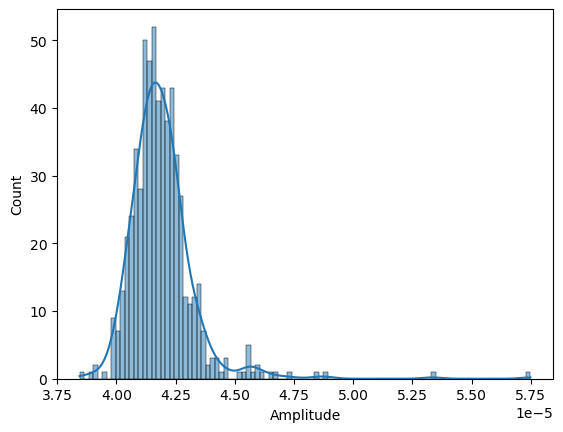

In [8]:
def find_avg_signal(file_path, graph=False):
    df = pd.read_csv(file_path, sep = '\t', skiprows = 1, names = ['Frequency', 'Amplitude'])
    if graph:
        sns.histplot(data =df, x= 'Amplitude', bins = 100, kde= True)
    hist, bin_edges = np.histogram(df['Amplitude'], bins=200, density = False)
    eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges), num = 200)
    return eval_points[np.argmax(scipy.stats.gaussian_kde(df['Amplitude']).pdf(eval_points))]

find_avg_signal('calibration_data/calibrate_-2_0.dat', graph=True)

In [9]:
def gauss2d(xy, amp, x0, y0, a, c):
    x, y = xy
    inner = a * (x - x0)**2 + c * (y - y0)**2
    return amp * np.exp(-inner)

In [10]:
def plot_2D(xy, fobs, pred_params):
    xi, yi = xy
    x = np.linspace(-9, 9, 100)
    y = np.linspace(-9, 9, 100)
    xx, yy = np.meshgrid(x,y)
    xyi = np.vstack([xx.ravel(), yy.ravel()])
    fpred = gauss2d(xyi, *pred_params).reshape((100, 100))
    plt.scatter(xi, yi, c=fobs, s=300, vmin=fpred.min(), vmax=fpred.max(), linewidth=1, edgecolor='k', marker = 'X')
    plt.margins(1)
    plt.imshow(fpred, extent=[-9, 9, -9, 9], aspect='auto', origin='lower')
    plt.colorbar()
    
def plot_2D_scatter(xy, fobs, pred_params):
    xi, yi = xy
    x = np.linspace(-9, 9, 100)
    y = np.linspace(-9, 9, 100)
    xx, yy = np.meshgrid(x,y)
    xyi = np.vstack([xx.ravel(), yy.ravel()])
    fpred = gauss2d(xyi, *pred_params).reshape((100, 100))
    plt.scatter(xi, yi, c=fobs, s=300, vmin=fpred.min(), vmax=fpred.max(), linewidth=1, edgecolor='k', marker = 'X')
    plt.margins(1)
    # plt.imshow(fpred, extent=[-9, 9, -9, 9], aspect='auto', origin='lower')
    plt.colorbar()

<Axes: >

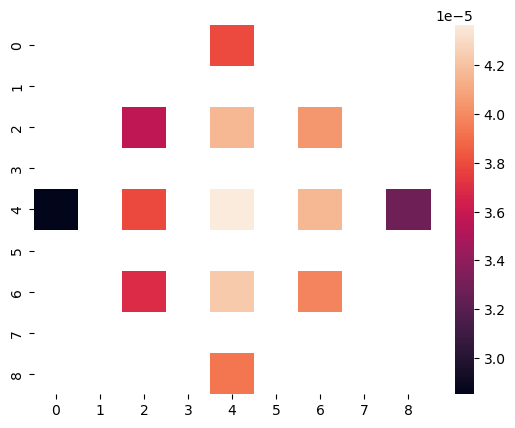

In [11]:
data_map = np.empty((9,9))
data_map[:] = np.nan
fobs = np.array([])
xi = np.array([])
yi = np.array([])

for path in glob.glob('calibration_data\calibrate_*.dat'):
    index = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", path[0:-4])
    xi = np.append(xi, int(index[0]))
    yi = np.append(yi, int(index[1]))
    fobs = np.append(fobs, find_avg_signal(path))
    data_map[int(index[0])+4, int(index[1])+4] = find_avg_signal(path)
# print(fobs)
sns.heatmap(data_map)

C:\Users\Dennis Wu\AppData\Local\Temp\ipykernel_14824\3639787110.py:4: RuntimeWarning: overflow encountered in exp
  return amp * np.exp(-inner)


Estimated calibration: [0.235271   0.48146082 0.00732426 0.02212103] degrees
Residual, RMS(obs - pred): 4.373383127057382e-07


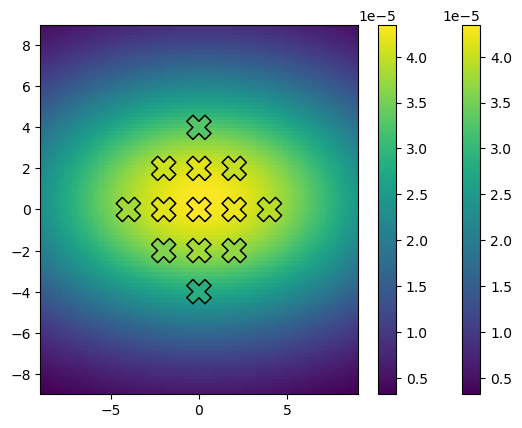

In [12]:
guess = [4e-5, -0.5, 0.1, 1, 1]
pred_params, uncert_cov = scipy.optimize.curve_fit(gauss2d, xdata = (xi,yi), ydata = fobs, p0=guess)
fpred = gauss2d((xi,yi), *pred_params)
print('Estimated calibration:', pred_params[1:], "degrees") 
print('Residual, RMS(obs - pred):', np.sqrt(np.mean((fobs - fpred)**2)))
plot_2D((xi,yi), fobs, pred_params)



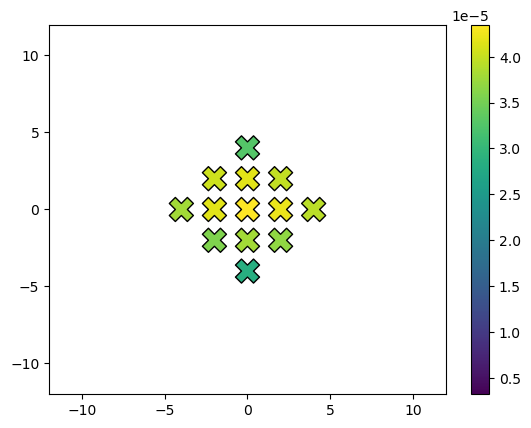

In [13]:
plot_2D_scatter((xi,yi), fobs, pred_params)